In [1]:
import os
import argparse
import sys
import platform
import time
import configparser as ConfigParser
from shutil import copyfile
from config.settings import *
import pandas as pd
from images import *
# metrics
import torch
from torchmetrics import ConfusionMatrix
from torchmetrics.functional import dice_score
from torchmetrics.functional import f1

# Evaluate predict, target

In [2]:
# Training settings
st = Settings()
options = st.get_options()

# set task to train
options['task'] = 'training'
if options['task'] =='training':
    folder = 'train_folder'
else: folder = 'test_folder'
# list scan
fold = 0
# fold train data
df = pd.read_csv(options['train_csv_path'])
# select training scans
train_files = df.loc[df['fold'] != fold, ['patient_id','study']].values
valid_files = df.loc[df['fold'] == fold, ['patient_id', 'study']].values
train_scan_list = [f[0]+f[1] for f in train_files]
valid_scan_list = [f[0]+f[1] for f in valid_files]


valid_scan_list.sort()
train_scan_list.sort()

In [3]:
df

,root_path,patient_id,study,lesion,FLAIR,T1,fold
0,/home/mostafa/Marwa/DataSets/ISBI/train/traini...,training03,_05,lesion.nii.gz,FLAIR_brain.nii.gz,T1_brain.nii.gz,4
1,/home/mostafa/Marwa/DataSets/ISBI/train/traini...,training01,_03,lesion.nii.gz,FLAIR_brain.nii.gz,T1_brain.nii.gz,0
2,/home/mostafa/Marwa/DataSets/ISBI/train/traini...,training01,_02,lesion.nii.gz,FLAIR_brain.nii.gz,T1_brain.nii.gz,2
3,/home/mostafa/Marwa/DataSets/ISBI/train/traini...,training01,_01,lesion.nii.gz,FLAIR_brain.nii.gz,T1_brain.nii.gz,3
4,/home/mostafa/Marwa/DataSets/ISBI/train/traini...,training03,_03,lesion.nii.gz,FLAIR_brain.nii.gz,T1_brain.nii.gz,1
5,/home/mostafa/Marwa/DataSets/ISBI/train/traini...,training02,_01,lesion.nii.gz,FLAIR_brain.nii.gz,T1_brain.nii.gz,0
6,/home/mostafa/Marwa/DataSets/ISBI/train/traini...,training05,_02,lesion.nii.gz,FLAIR_brain.nii.gz,T1_brain.nii.gz,4
7,/home/mostafa/Marwa/DataSets/ISBI/train/traini...,training03,_04,lesion.nii.gz,FLAIR_brain.nii.gz,T1_brain.nii.gz,0
8,/home/mostafa/Marwa/DataSets/ISBI/train/traini...,training01,_04,lesion.nii.gz,FLAIR_brain.nii.gz,T1_brain.nii.gz,1
9,/home/mostafa/Marwa/DataSets/ISBI/train/traini...,training04,_03,lesion.nii.gz,FLAIR_brain.nii.gz,T1_brain.nii.gz,2


In [4]:
#scan_list = valid_scan_list+train_scan_list
#scan_list = train_scan_list
scan_list = valid_scan_list
scan_list.sort()
scan_list

['training01_03',
 'training02_01',
 'training03_04',
 'training04_02',
 'training05_04']

# post process segments

In [6]:
#options['experiment']='resnet_DAN_full_isbi_train3'
options['experiment'] = 'resnet_DAN_full_miccai_train2'
options['pre_trained_model'] = '1_model.pth'

In [7]:

accuracy_df=pd.DataFrame(columns=['patient_id', 'study', 'dice_score', 'tpr', 'fpr', 'f1'])
confmat = ConfusionMatrix(num_classes=2)

for scan in scan_list:
    patient_id,study = scan.split('_')[0],scan.split('_')[1]
    path=os.path.join(options[folder],scan)
    lesion_path = os.path.join(path, 'tmp/lesion.nii.gz')
    #predicted_path = os.path.join(path, options['experiment'],options['experiment'] +'_hard_seg.nii.gz')
    predicted_path = os.path.join(path, options['experiment'],options['experiment'] +'_debug_prob_0.nii.gz')
    
    target=load_img(lesion_path)
    predict=load_img(predicted_path)

    target = torch.from_numpy(target).to(torch.uint8)
    predict = torch.from_numpy(predict).to(torch.uint8)
    
    convm = confmat(predict, target)
    tn, fp, fn, tp = convm.ravel()
    tn, fp, fn, tp =tn.item(), fp.item(), fn.item(), tp.item()
    tpr=tp/(tp+fn)
    fpr=fp/(fp+tp)
    dice = 2 * tp /(2 * tp + fp + fn)
    #dice_score(predict, target, bg=True)
    #dice_score(predict, target)
    f1_value = f1(predict, target, num_classes=2,mdmc_average='global').item()

    df = pd.DataFrame([[patient_id, study, dice, tpr, fpr, f1_value ]], columns=['patient_id', 'study', 'dice_score', 'tpr', 'fpr', 'f1'])
    accuracy_df=accuracy_df.append(df)



In [ ]:
#train

In [22]:
accuracy_df

,patient_id,study,dice_score,tpr,fpr,f1
0,training01,01,0.821909,0.919397,0.256888,0.999022
0,training01,02,0.743320,0.991656,0.405546,0.998557
0,training01,04,0.678116,0.784853,0.403065,0.998278
0,training02,02,0.187766,0.158446,0.769598,0.993944
0,training02,03,0.186058,0.156824,0.771311,0.993921
0,training02,04,0.183460,0.153002,0.770940,0.993806
0,training03,01,0.037191,0.085643,0.976247,0.996264
0,training03,02,0.033282,0.084916,0.979303,0.996347
0,training03,03,0.030211,0.076879,0.981201,0.996333
0,training03,05,0.030967,0.078163,0.980692,0.996329


In [ ]:
# all train data

In [17]:
accuracy_df

,patient_id,study,dice_score,tpr,fpr,f1
0,training01,01,0.821909,0.919397,0.256888,0.999022
0,training01,02,0.743320,0.991656,0.405546,0.998557
0,training01,03,0.718238,0.943790,0.420302,0.998143
0,training01,04,0.699128,0.997808,0.461935,0.998016
0,training02,01,0.789309,0.953778,0.326780,0.998074
0,training02,02,0.885280,0.969368,0.185384,0.998890
0,training02,03,0.881006,0.972312,0.194624,0.998836
0,training02,04,0.803262,0.999227,0.328442,0.997774
0,training03,01,0.593081,0.998831,0.578246,0.998845
0,training03,02,0.629519,0.977584,0.535769,0.999148


In [19]:
accuracy_df

,patient_id,study,dice_score,tpr,fpr,f1
0,training01,01,0.821909,0.919397,0.256888,0.999022
0,training01,02,0.743320,0.991656,0.405546,0.998557
0,training01,03,0.718238,0.943790,0.420302,0.998143
0,training01,04,0.678116,0.784853,0.403065,0.998278
0,training02,01,0.177030,0.159601,0.801269,0.994387
0,training02,02,0.187766,0.158446,0.769598,0.993944
0,training02,03,0.186058,0.156824,0.771311,0.993921
0,training02,04,0.183460,0.153002,0.770940,0.993806
0,training03,01,0.037191,0.085643,0.976247,0.996264
0,training03,02,0.033282,0.084916,0.979303,0.996347


In [ ]:
# validation

In [8]:
#miccai full train
accuracy_df

,patient_id,study,dice_score,tpr,fpr,f1
0,training01,03,0.281499,0.226355,0.627836,0.997103
0,training02,01,0.400793,0.300684,0.399168,0.996599
0,training03,04,0.221826,0.264490,0.808986,0.998649
0,training04,02,0.256320,0.729508,0.844526,0.998692
0,training05,04,0.303819,0.458362,0.772789,0.998705


In [9]:
print('dice_score: ',df["dice_score"].mean())
print('tpr: ',df["tpr"].mean())
print('fpr: ',df["fpr"].mean())

dice_score:  0.3038185255198488
tpr:  0.45836185261236595
fpr:  0.7727889617733544


<AxesSubplot:>

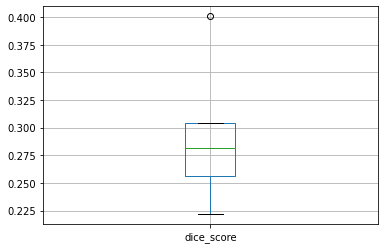

In [10]:
accuracy_df.boxplot(column=['dice_score'])

In [9]:
#isbi full train
accuracy_df

,patient_id,study,dice_score,tpr,fpr,f1
0,training01,03,0.718238,0.943790,0.420302,0.998143
0,training02,01,0.789309,0.953778,0.326780,0.998074
0,training03,04,0.524647,0.991113,0.643255,0.998692
0,training04,02,0.422720,0.954007,0.728486,0.999195
0,training05,04,0.449907,0.995893,0.709407,0.998499


In [ ]:
print('dice_score: ',df["dice_score"].mean())
print('tpr: ',df["tpr"].mean())
print('fpr: ',df["fpr"].mean())

<AxesSubplot:>

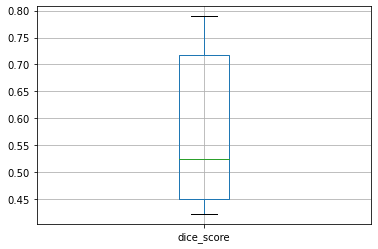

In [10]:
#hard_seg
accuracy_df.boxplot(column=['dice_score'])

In [9]:
#prob_1
accuracy_df

,patient_id,study,dice_coefficient,tpr,fpr
0,training01,01,0.499024,0.5,0.5
0,training01,02,0.534828,0.5,0.5
0,training01,03,0.504277,0.5,0.5
0,training01,04,0.513522,0.5,0.5
0,training02,01,0.572913,0.5,0.5
0,training02,02,0.576917,0.5,0.5
0,training02,03,0.623156,0.5,0.5
0,training02,04,0.643848,0.5,0.5
0,training03,01,0.464388,0.5,0.5
0,training03,02,0.455096,0.5,0.5


<AxesSubplot:>

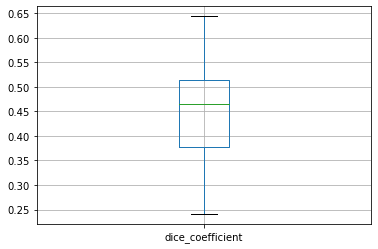

In [8]:
accuracy_df.boxplot(column=['dice_coefficient'])

<AxesSubplot:>

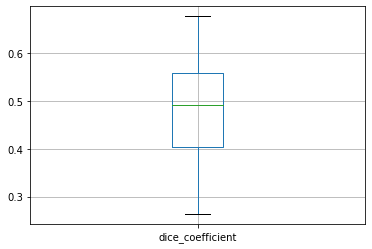

In [3]:
#threshold = 4
accuracy_df.boxplot(column=['dice_coefficient'])